<a href="https://colab.research.google.com/github/ashmibanerjee/FTL-bigdatahack-yahoo-starter/blob/master/FTL_finance_track.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the Yahoo Finance Data Workshop
### Objectives:

  1) How to access data from Yahoo finance 

  2) Understanding the data + statistics
  
  3) Predicting future trends of stock prices
 

*Probable problem statements in the end*

*** This cell installs required packages and dependencies. Should be run only once during the entire process***

In [10]:
!pip install Prophet
!pip install yfinance
!pip install mpl_finance
!pip install --upgrade statistics
!pip install fbprophet

Requirement already up-to-date: statistics in c:\programdata\anaconda3\lib\site-packages (1.0.3.5)
^C


# Imports

In [3]:
import calendar
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#from fbprophet import Prophet
#from google.colab import drive
import yfinance as yf
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
import statistics as stat 
from scipy.stats.mstats import gmean

# Helpers

In [4]:
def plot_box_plot(df):
    """ 
    Boxplot to show the difference between trend and season 
    Trend is shown in the boxplot with a year comparison.
    Season is shown in the boxplot with a month comparison. 
    """
    df['year'] = [d.split('-')[0] for d in df['Date']] # Trend
    df['month'] = [d.split('-')[1] for d in df['Date']] # Season
    
    # Draw Plot
    fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
    sns.boxplot(x='year', y='Close', data=df, ax=axes[0], color='white')
    sns.boxplot(x='month', y='Close', data=df, color='white') 

    # Set Title
    axes[0].set_title('Trend', fontsize=18);
    axes[1].set_title('Season', fontsize=18)

    # Set plot labels
    axes[0].set(xlabel='Year', ylabel='Closed price')
    axes[1].set(xlabel='Month', ylabel='Closed price')

    plt.show()


def plot_timeseries(df):
  """
  Plot DataFrame TimeSeries
  """
  df[['Date', 'Close']].set_index('Date').plot(figsize=(20,7))


def pre_process_df(df):
  """
  Preprocessing of Prophet: prophet requires the columns to be named in this specific way
  """
  df = df.rename(columns={'Date': 'ds', 'Close': 'y'})
  return df


def get_train_test_data(df):
    """
    Get train and test data for a TimeSeries training model process
    """
    end_train_data = int(len(data)*0.75)
    train_data = data.iloc[:end_train_data,:]
    test_data = data.iloc[end_train_data:,:]
    return train_data, test_data

In [5]:
def getYahooFinanceData(tick, prd):
  # Get data
  data_all = yf.Ticker(tick)

  # get historical data for the period
  data_period = data_all.history(period=prd)
  print('\n Number of Data points in the data: ', data_period.shape[0], '\n')
  #print(data_period)

  return data_period

def geometric_mean(ror): 
  ror = ror+1
  temp = 1
  n = 1/ror.shape[0]
  for ror_i in ror:
    temp = temp*ror_i
  #temp = [temp*ror_i for ror_i in ror]
  geo_mean = temp**n -1
  return geo_mean

# 1) Access Data from Yahoo Finance

- List of tickers on Yahoo Finance! [Ref](http://investexcel.net/all-yahoo-finance-stock-tickers/)

- Example of stocks / commodities / Crypto used in example: 
    
    - Facebook (FB) [YF](https://finance.yahoo.com/quote/FB?p=FB&.tsrc=fin-srch)
    - Gold (GC=F) [YF](https://finance.yahoo.com/quote/GC=F?p=GC=F)
    - Bitcoin (BTC-USD) [YF](https://finance.yahoo.com/quote/BTC-USD?p=BTC-USD&.tsrc=fin-srch)
  
Something to note: 

- Categories: 

    Large Cap -> Facebook, Microsoft, etc. 
    
    [Small Cap](https://www.investopedia.com/investing/introduction-to-small-cap-stocks/) -> [Examples](https://finance.yahoo.com/u/motif/watchlists/small-cap-stars/) 

    [Commodities](https://www.investopedia.com/investing/commodities-trading-overview/) -> grains, gold, beef, oil, and natural gas [etc.](https://finance.yahoo.com/commodities) 

    Crypto -> [On Yahoo finance](https://finance.yahoo.com/cryptocurrencies/)

    Foreign Exchange -> [On Yahoo finance](https://finance.yahoo.com/currencies/)

In [22]:
# Get data for Facebook
fb = yf.Ticker("FB")

# get historical market data
fb_1mo = fb.history(period="1mo")
print('Number of data points in the data is: ', fb_1mo.shape[0], '\n')
print(fb_1mo)
fb_1mo  =fb_1mo.reset_index()
## Data processing to convert dates to strings prior to plotting. 
fb_1mo['Date'] = [mdates.date2num(d) for d in fb_1mo['Date']]
# Similarly for other stocks

gld = getYahooFinanceData('GC=F', '1mo')
gld = gld.reset_index()
bitcoin = getYahooFinanceData('BTC-USD', 'max')
bitcoin = bitcoin.reset_index()
print('\n The data format from yahoo finance is: ', type(bitcoin))

Number of data points in the data is:  23 

              Open    High     Low   Close    Volume  Dividends  Stock Splits
Date                                                                         
2020-04-21  175.25  175.38  168.34  170.80  24850500          0             0
2020-04-22  178.45  184.78  178.14  182.28  33369900          0             0
2020-04-23  184.08  187.05  183.15  185.13  21426600          0             0
2020-04-24  183.23  190.41  180.83  190.07  28868500          0             0
2020-04-27  192.66  193.75  187.41  187.50  29197800          0             0
2020-04-28  188.66  189.20  182.56  182.91  21731000          0             0
2020-04-29  190.93  196.91  190.00  194.19  45954500          0             0
2020-04-30  206.92  209.69  201.57  204.71  46230100          0             0
2020-05-01  201.60  207.28  199.05  202.27  30415600          0             0
2020-05-04  200.20  205.91  198.76  205.26  19250700          0             0
2020-05-05  207.02  

#### Helpful Tip: Look at **pandas**

# Understanding the data: 

1) Market Cap: Market capitalization refers to the total dollar market value of a company's outstanding shares of stock.  [Ref](https://www.investopedia.com/terms/m/marketcapitalization.asp)

2) Open: The starting value at which the stock was traded [Ref](https://www.investopedia.com/terms/o/open.asp)

3) High: Highest value during the day at which the stock was traded

4) Low: Lowest value during the day at which the stock was traded

5) Close: Value of the last trade on this  [Ref](https://www.investopedia.com/terms/c/close.asp)

6) Adj Close (Adjusted closing price): Adjusted closing price amends a stock's closing price to accurately reflect that stock's value after accounting for any corporate actions. It is considered to be the true price of that stock and is often used when examining historical returns or performing a detailed analysis of historical returns. [Ref](https://www.investopedia.com/terms/a/adjusted_closing_price.asp)

7) Volume: Trading volume is a measure of how much of a given financial asset has traded in a period of time. [Ref](https://www.investopedia.com/articles/technical/02/010702.asp)


In [7]:
bitcoin.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2014-09-17,465.86,468.17,452.42,457.33,21056800,0,0
1,2014-09-18,456.86,456.86,413.10,424.44,34483200,0,0
2,2014-09-19,424.10,427.83,384.53,394.80,37919700,0,0
3,2014-09-20,394.67,423.30,389.88,408.90,36863600,0,0
4,2014-09-21,408.08,412.43,393.18,398.82,26580100,0,0


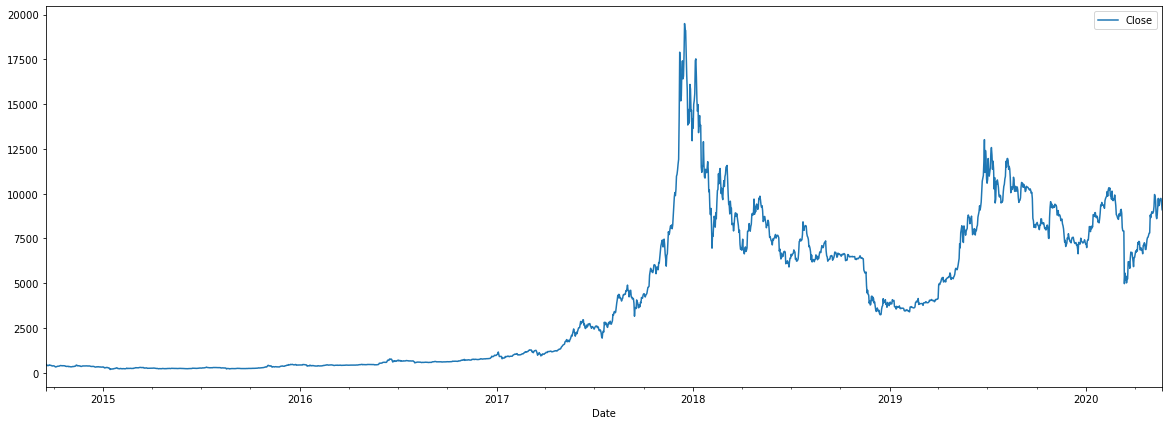

In [8]:
plot_timeseries(bitcoin)

### [Stock Charts Example](https://www.mit.edu/~mbarker/formula1/f1help/11-ch-10.htm)


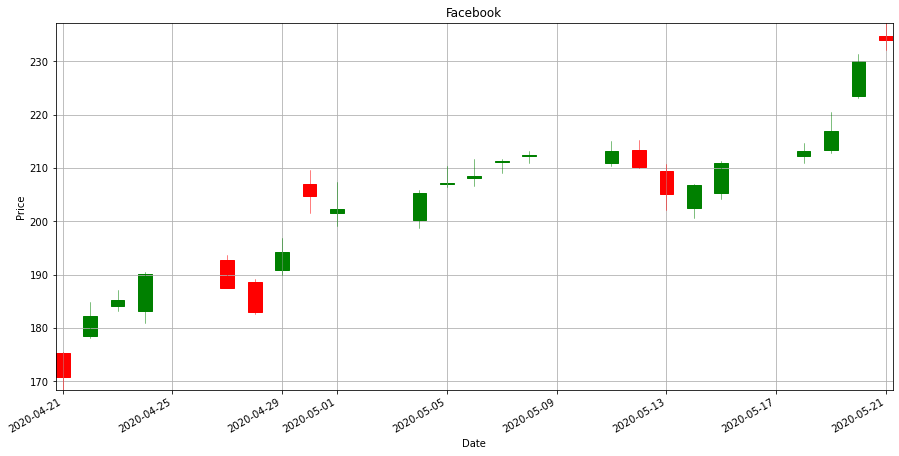

In [25]:
## Plotting the candlestick figure
fig, ax = plt.subplots(figsize=(15, 7.5))
candlestick_ohlc(ax, fb_1mo[['Date', 'Open', 'High','Low', 'Close']].values, width=0.5, colorup='g', colordown='r')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Facebook')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gcf().autofmt_xdate()   # Beautify the x-labels
plt.autoscale(tight=True)
plt.grid()

# Calculating Rate of Return on the Stock

The return of an asset ***over a given period*** is the change in price plus any cash payout received normalized by the beginning-of-period price. 
   
   $Return_t = \frac{Price_t-Price_{t-1}}{Price_{t-1}}$
   
**Arithematic Average Return**

$r = \frac{1}{n}(r_1+r_2+r_3+...+r_n)$

Useful for forecasting the return next period based on past experience

**Geometric Average Return**

$r = [(1+r_1)(1+r_2)(1+r_3)...(1+r_n)]^{1/n}-1$

Gives the equivalent per-period return (useful for buy-and-hold investors)

### **Example**

Suppose the return for an emerging markets fund in Year 1 is 100% and -50% in Year 2. 
#### <ins>Aritmetic Average of returns: 

$(1 + -0.5)/2 = 0.25$

Thus, without reinvesting gains/losses, the investor would have gained 100€ in Year 1 and lost 50€ in Year 2, or a total of <ins>*50€ in gains over two years*. 

#### <ins>**Geometric average of returns:**
    
$[(1+1.000)(1-0.05)]^{1/2}-1 = 0$

In this case the investor reinvests the gains in the second year-> <ins>*Buy and Hold* 

The final return is the geometric average return which amounts to <ins>0% 



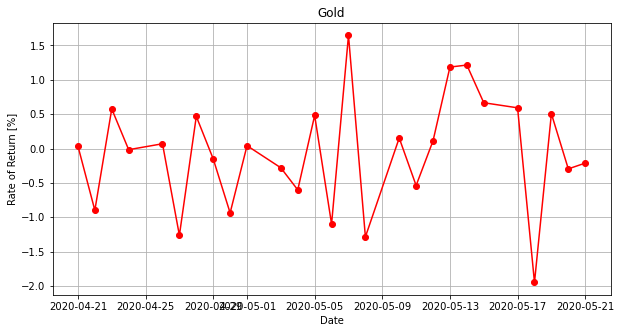

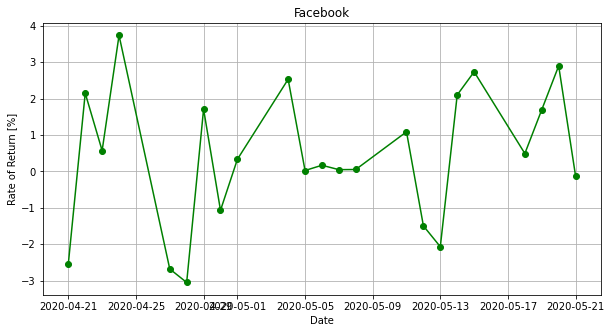

In [19]:
# Calculate ROR for each day
# Assumption: stocks are bought at the start of the day (with opening price) and sold at the end of the day (with closing price).
# ROR_perday = (close-open)/open

ror_gold = 100*(gld.loc[:,'Close'] - gld.loc[:,'Open'])/gld.loc[:,'Open']
ror_facebook = 100*(fb_1mo.loc[:,'Close'] - fb_1mo.loc[:,'Open'])/fb_1mo.loc[:,'Open']

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot_date(gld.loc[:,'Date'], ror_gold, 'r-o')
plt.xlabel('Date')
plt.ylabel('Rate of Return [%]')
plt.title('Gold')
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot_date(fb_1mo.loc[:,'Date'], ror_facebook, 'g-o')
plt.xlabel('Date')
plt.ylabel('Rate of Return [%]')
plt.title('Facebook')
plt.grid()
plt.show()

In [20]:
# Expected Rate of Return over time period of 1 month
expectAM_ror_gold = stat.mean(ror_gold)
expectGM_ror_gold = geometric_mean(ror_gold)

expectAM_ror_fb = stat.mean(ror_facebook)
expectGM_ror_fb = geometric_mean(ror_facebook)

print('The expected rate of return (arithmetic average) for gold in the last month is:', expectAM_ror_gold, ' % \n')
print('The expected rate of return (geometric average) for gold in the last month is:', expectGM_ror_gold, ' % \n')
print('The expected rate of return (arithmetic average) for gold in the last month is:', expectAM_ror_fb, ' % \n')
print('The expected rate of return (geometric average) for gold in the last month is:', expectGM_ror_fb, ' % \n')

The expected rate of return (arithmetic average) for gold in the last month is: -0.0661974523605828  % 

The expected rate of return (geometric average) for gold in the last month is: -0.2352746873770999  % 

The expected rate of return (arithmetic average) for gold in the last month is: 0.4034293867710496  % 

The expected rate of return (geometric average) for gold in the last month is: 0.5519607643961943  % 



## Some more statistics

#### Average (Arithmetic) Expected Return
$E(R) = \sum_N p_nR_n$

where, $p_n$ is the probability of the return

#### Variance
- The average of the squared differences from the Mean. [Ref.](https://www.mathsisfun.com/data/standard-deviation.html)

  $VAR(R) = \sum_N p_n [R_n-E(R_n)]^2$

#### Standard Deviation
- The Standard Deviation is a measure of how spread out numbers are. [Ref.](https://www.mathsisfun.com/data/standard-deviation.html)

  $\sigma = \sqrt{VAR(R)}$

#### Covariance
- Covariance is a measure of how much two random variables vary together. [Ref.](https://www.statisticshowto.com/covariance/)
##### Formula
$COV(R_1, R_2) = \sum_N p_n [R_{1,n}-E(R_{1,n})][R_{2,n}-E(R_2,n)]$

#### Correlation Coefficient
- measure of the strength of the relationship between the relative movements of two variables. [Ref.](https://www.investopedia.com/terms/c/correlationcoefficient.asp)
- positive correlation: both variables move in tandem. ie. both assets increase or decrease together. [Ref.](https://www.investopedia.com/terms/p/positive-correlation.asp)
- negative correlation / inverse correlation: both variables move opposite to each other [Ref.](https://www.investopedia.com/terms/i/inverse-correlation.asp)
##### Formula
$\eta = \frac{COV(R_1, R_2)}{\sigma_1 \sigma_2}$ 

In [21]:
gold_std = stat.stdev(ror_gold)

print('Standard Deviation for the rate of return: ', gold_std, '\n')

gold_variance = stat.variance(ror_gold)

print('Variance for the rate of return for gold: ', gold_variance, '\n')

fb_std = stat.stdev(ror_facebook)

print('Standard Deviation for the rate of return: ', fb_std, '\n')

fb_variance = stat.variance(ror_facebook)

print('Variance for the rate of return for gold: ', fb_variance, '\n')

Standard Deviation for the rate of return:  0.8357339656700469 

Variance for the rate of return for gold:  0.6984512613745831 

Standard Deviation for the rate of return:  1.9031836473489525 

Variance for the rate of return for gold:  3.622107995536462 



# Investment Portfolio: 
A portfolio is a grouping of financial assets such as stocks, bonds commodities, currencies and cash equivalents, as well as their fund counterparts, including mutual, exchange-traded and closed funds. [Ref](https://www.investopedia.com/terms/p/portfolio.asp)

Example: consider you have 100 € to invest and
You buy the following stocks (assumptions in the bracket):

1) Amazon - 50 €  (ROR: 12% STD: 20)

2) Lufthansa - 10 € (ROR: -5% STD: 50)

3) Inveox - 40 € (ROR: 25% STD: 75 )

The above three stocks become combined become your portfolio. The Rate of return of the portfolio is the weighted avergae of individual rate of returns. 

Similarly, the standard deviation is the weighted average of the individual standard deviations. 

-------------------------------------------------------------------------------

### **Think about it:**

What does correlation between two stocks signify? 

How will correlation affect your rate of return or standard deviation? 

--------------------------------------------------------------------------------

While building up a portfolio as a general rule of thumb good investors look for two things...

1) Highest rate of returns

2) Low standard deviation

# 3) Machine Learning

In [ ]:
# This will prompt for authorization.
drive.mount('/content/drive')

In [ ]:
%cd "/content/drive/My Drive/FTL Team/FTL Hackathons/05 - Events/Big Data and Global Effects/Workshops/Yahoo Finance/data/"

In [ ]:
os.getcwd()
original = pd.read_csv("DLAKF.csv")
original.shape
original

In [ ]:
plot_timeseries(original)

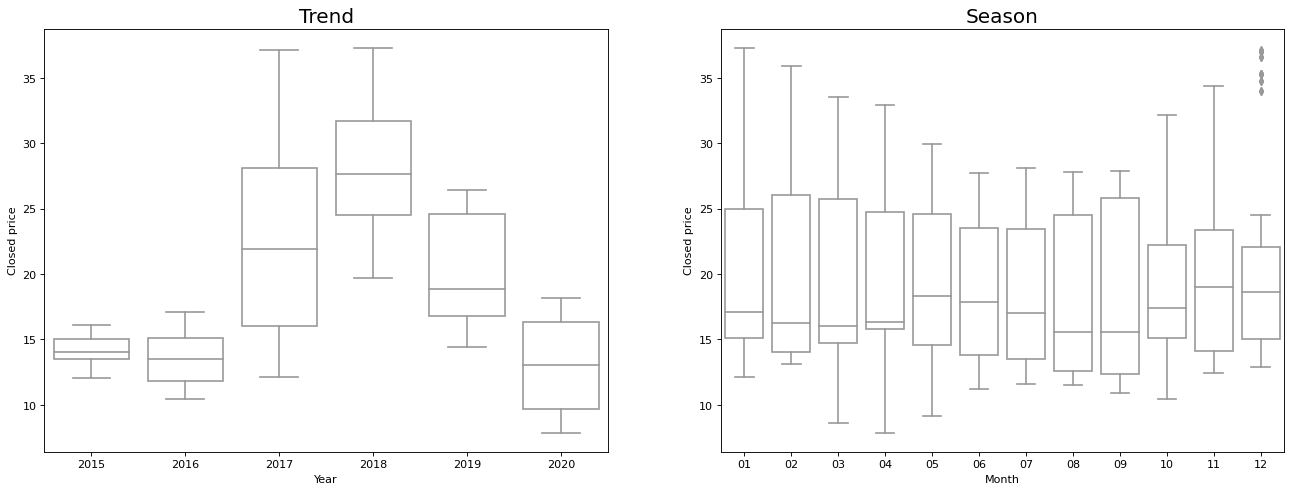

In [0]:
plot_box_plot(original)

## Choose Model, train it, test it and repeat

We will use Prophet in this example.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


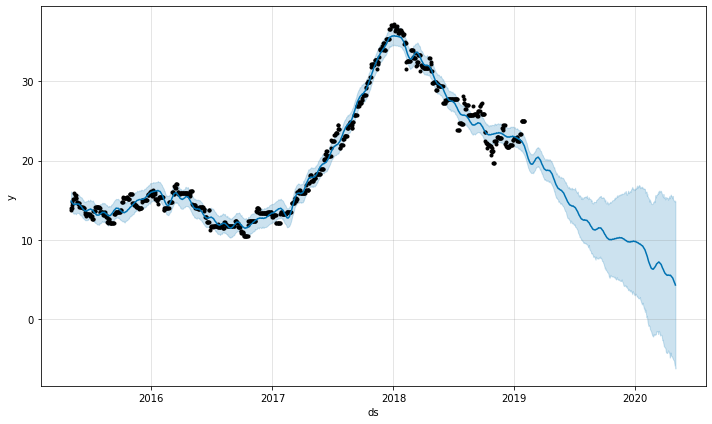

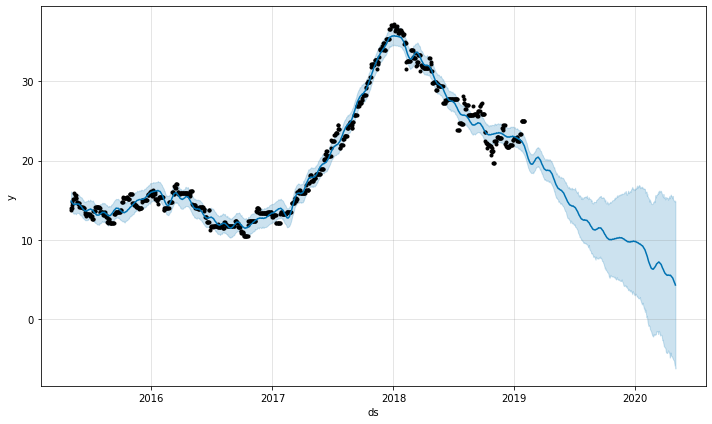

In [0]:
model = Prophet()
data = pre_process_df(original)
train_data, test_data = get_train_test_data(data)
model_fit = model.fit(train_data)
forecast = model_fit.predict(data)
model.plot(forecast)

## Forecast

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


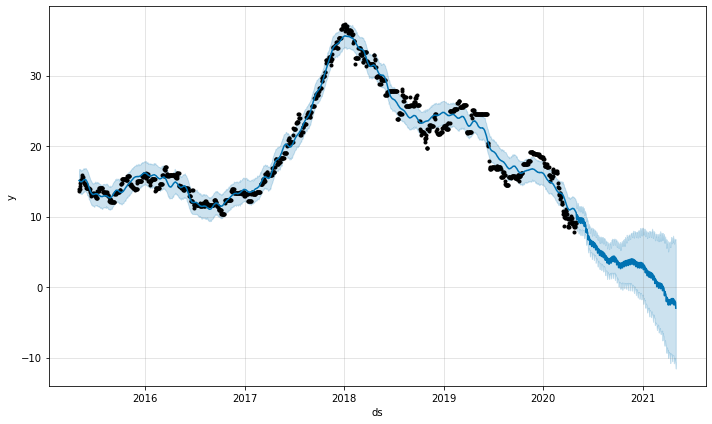

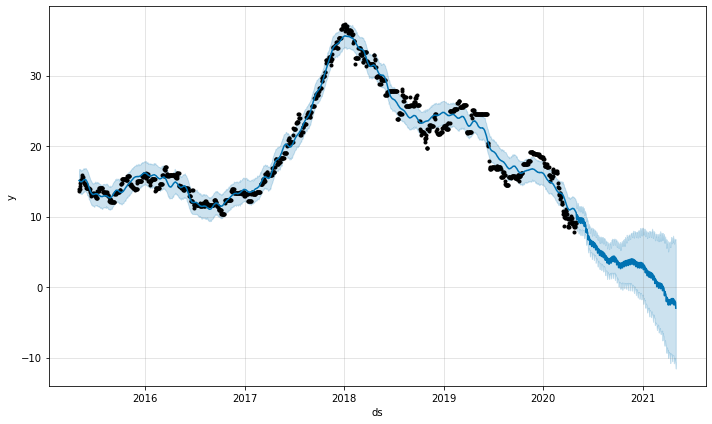

In [0]:
model = Prophet()
data = pre_process_df(original)
model_fit = model.fit(data)
data_forecast = model.make_future_dataframe(periods=365)
forecast = model_fit.predict(data_forecast)
model.plot(forecast)

## Probable problem statements while analyzing the data: 

#### 1) Which companies/ stocks seem to cope with the pandemic better/worde and why?
    
    - does it depend on the type of the service or product?

    - does the work-from-home / stay-indoors lifestyle change has had major impact on the some of the stocks?  

    - what does historical data from similar situations have to tell you about the aftermaths? [SARS](https://www.who.int/ith/diseases/sars/en/)

#### 2) What is the best and the worst portfolios one could invest in during and after the pandemic? 

    - here certain number of assumptions need to be made- For eg: trends of opening and closing, returns, standard deviations etc. 


#### 3) Predicting returns on a portfolio bought during the pandemic on a long term? 

    - will saving on stocks bought now, when the market seems to be in a declining state (poor or negative rate of return) will be compensated by long term returns on the the portfolio suggested? 



# Some helful tips: 

### Questions you should ask yourself while choosing an asset to add to your portfolio...
#### 1) Does it make good sense to hold the asset? 
#### 2) How has the asset performed in the past? (Past performance does not gurantee future performance) 
#### 3) How does one asset co-relate with another assets in my portfolio? 
### To include
- Things to look out for
    1. Expected return
    2. How the assets in the portfolio correlate with each other
    3. Past performance is not a gurantee of future performance. 

## Key Firm Characteristics for Investment

1) **Size:** Measured as market value ([market cap](https://www.investopedia.com/terms/m/marketcapitalization.asp)) of common stock outstanding. Firms can be classified as small vs. large. 

2) Book-to-market ratio: 

Measured by the book value of firm to the market value. Firms with tangible assets have higher book to market ratio and firms with untagible assets have lower book to market ratio. For example: A cement company will have a high book to market ratio while google or any software company will have a low book to market ratio. 
Book to market ratio indicates if the stock is overvalued or undervalued. [More reading](https://www.investopedia.com/terms/b/booktomarketratio.asp)

**Note: there are other factors into play while calculating the book to market ratio.**

3) Momentum: Performance of a firm over the past year seems to predict the firm’s stock return over thenext month (both positively and negatively).

4) Industry

## Definitions and Formulas

1) Future Value : The value of a current asset at a future date based on an assumed rate of growth. [More Reading](https://www.investopedia.com/terms/f/futurevalue.asp)

2) Ownership investment: those investements where you own an interest in some company or other asset (such as stockm real estatem or a small buisness) that has the ability to generate revenue and profits. 
**Stocks are an example of ownership investement**

3) Asset: An asset is a resource with economic value that an individual, corporation, or country owns or controls with the expectation that it will provide a future benefit.

4) Inflation: A quantitative measure of the rate at which the average price level of a basket of selected goods and services in an economy increases over some period of time.

5) Buy and Hold investement: Buy and hold is a passive investment strategy in which an investor buys stocks (or other types of securities such as ETFs) and holds them for a long period regardless of fluctuations in the market. [More Reading](https://www.investopedia.com/terms/b/buyandhold.asp)

6) Equity risk premium: Equity risk premium refers to the excess return that investing in the stock market provides over a risk-free rate. [More Reading](https://www.investopedia.com/terms/e/equityriskpremium.asp)


### Interesting reads: 

1) **[Zero Cost Strategy](https://www.investopedia.com/terms/z/zero-cost-strategy.asp)** 